In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dset

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, sampler, Dataset
from pytorch_load_data import load_data

from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import copy

plt.ion()   # interactive mode

In [2]:
batchSize = 64
num_classes = 19

dataloaders, poster_train, poster_val, poster_test = load_data(batchSize, -1)
dataset_sizes = {}
dataset_sizes['train'] = len(dataloaders['train'])
dataset_sizes['val'] = len(dataloaders['val'])

In [3]:
poster_train[0][1]

[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def train_model(model, optimizer, num_epochs=25):
    since = time.time()
    n_classes= 19

    best_model_wts = copy.deepcopy(model.state_dict())
    best_prec = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_precision = []
            running_recall = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                labels_tensor = torch.zeros((batchSize, num_classes))
                for idx,each in enumerate(labels):
                    labels_tensor[:,idx] = each

                inputs = inputs.to(device)
                labels = labels_tensor.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward -- track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    scores = model(inputs)
                    loss = multilabel_Loss(scores, labels)                        
                    print('Loss: %s' %(loss))
                    train_losses.append(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics --multilabel precision
                average_precision = average_precision_score(labels, scores.data, average="micro")
                print("Average precision: %s" %(average_precision))
                running_loss += loss.item() #* inputs.size(0)
                running_precision.append(average_precision)
#                 running_recall.append(np.mean(list_r))                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_prec = np.mean(running_precision)
#             epoch_recall = np.mean(running_recall)            
            
            if phase == 'val':
                epoch_val_precison.append(epoch_prec)
            else:
                epoch_train_precision.append(epoch_prec)

            print('END OF EPOCH')
            print('{} Loss: {:.4f} Prec: {:.4f}'.format(phase, epoch_loss, epoch_prec))

#             # deep copy the model
            if phase == 'val' and epoch_prec > best_prec:
                  best_prec = epoch_prec
                  best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Prec: {:4f}'.format(best_prec))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def multilabel_Loss(x, y):
    
    ## to calculate the log of the 
    shifted_logits = x - torch.max(x, dim=1, keepdim=True)[0]
    summed = torch.sum(torch.exp(shifted_logits), dim=1, keepdim=True)    
    log_probs = torch.log(torch.exp(shifted_logits) / summed)
    N, _ = x.size()
    
    p_loss = -1 * torch.sum(y * log_probs) / N    
    

    return p_loss

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)

# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

In [8]:
train_losses = []
epoch_train_precision = []
epoch_val_precison = []

learning_rates = [1e-6, 1e-4, 1e-2, 1e-1]

for learn_rt in learning_rates:
    optimizer_conv = optim.Adam(model_conv.parameters(), lr=learn_rt)
    model_conv = train_model(model_conv, optimizer_conv, num_epochs=5)

Epoch 0/4
----------
Loss: tensor(7.9209)
Average precision: 0.13824352891203812
Loss: tensor(7.9666)
Average precision: 0.14361613402118767
Loss: tensor(7.3015)
Average precision: 0.14447359323056772
Loss: tensor(7.5809)
Average precision: 0.13147043418386573
Loss: tensor(7.0943)
Average precision: 0.1152821589393349


KeyboardInterrupt: 

Text(0.5,0,'Iteration')

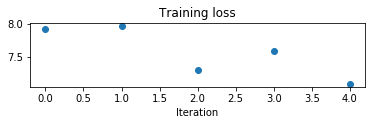

In [9]:
plt.subplot(311)
plt.title('Training loss')
plt.plot(train_losses, 'o')
plt.xlabel('Iteration')